# Learning to Search Feasible and Infeasible Regions of Routing Problems with Flexible Neural k-Opt

Thank you for your interest in our work!

In this notebook, I will provide some demos on how to run and play with our NeuOpt framework.
Hope this helps with your project :)

For any queries and potential collaboration, please email me at: yiningma@u.nus.edu
The code is free to use for personal and academic usage. For other purposes, please contact me.

The code is based on the following paper:

Yining Ma, Zhiguang Cao, and Yeow Meng Chee, “Learning to Search Feasible and Infeasible Regions of Routing Problems with Flexible Neural k-Opt”, in Advances in Neural Information Processing Systems, vol. 36, 2023.

In [1]:
import os
import json
import torch
import pprint
import numpy as np
import random
from tensorboard_logger import Logger as TbLogger
import warnings

from problems.problem_tsp import TSP
from problems.problem_cvrp import CVRP
from agent.ppo import PPO
from tqdm.notebook import tqdm

## A. NeuOpt Examples on TSP-50
### 1. Initialize the hyper-parameters

In our code, we use the file 'options.py' and the variable 'opts' to store all hyper-parameters.

In [2]:
from options import get_options
opts = get_options('')
opts

Namespace(problem='tsp', graph_size=20, dummy_rate=0.5, eval_only=False, init_val_met='random', no_cuda=False, no_tb=False, no_saving=False, no_DDP=False, use_assert=False, seed=6666, val_m=1, stall_limit=10, k=4, wo_regular=True, wo_bonus=True, wo_RNN=False, wo_feature1=True, wo_feature3=True, wo_MDP='True', load_path=None, resume=None, epoch_start=0, K_epochs=3, eps_clip=0.1, T_train=200, n_step=4, batch_size=512, epoch_end=200, epoch_size=10240, val_size=1000, val_batch_size=1000, val_dataset=None, lr_model=8e-05, lr_critic=2e-05, lr_decay=0.985, warm_up=2, max_grad_norm=0.05, v_range=6.0, critic_head_num=4, actor_head_num=4, embedding_dim=128, hidden_dim=128, n_encode_layers=3, normalization='layer', gamma=0.999, T_max=1000, no_progress_bar=False, log_dir='logs', log_step=50, record=False, output_dir='outputs', run_name='run_name_20231027T165133', checkpoint_epochs=1, wo_feature2=True, world_size=0, distributed=False, use_cuda=False, save_dir='outputs/tsp_20/run_name_20231027T16513

### 2. Set the hyper-parameters
We now try to test the pre-trained NeuOpt model with K=4 on 10 TSP-20 instances. The initial solutions are randomly initialized and we turn off the tensorboard logging and model saving functions.

In [3]:
opts.problem = 'tsp' 
opts.graph_size = 50
opts.val_dataset='./datasets/tsp_50.pkl'
opts.init_val_met = 'random'
opts.no_saving = True
opts.no_tb = True
opts.val_size = 10
opts.load_path = './pre-trained/tsp50.pt'
opts.device = torch.device("cuda" if opts.use_cuda else "cpu")
opts.no_progress_bar = True
opts

Namespace(problem='tsp', graph_size=50, dummy_rate=0.5, eval_only=False, init_val_met='random', no_cuda=False, no_tb=True, no_saving=True, no_DDP=False, use_assert=False, seed=6666, val_m=1, stall_limit=10, k=4, wo_regular=True, wo_bonus=True, wo_RNN=False, wo_feature1=True, wo_feature3=True, wo_MDP='True', load_path='./pre-trained/tsp50.pt', resume=None, epoch_start=0, K_epochs=3, eps_clip=0.1, T_train=200, n_step=4, batch_size=512, epoch_end=200, epoch_size=10240, val_size=10, val_batch_size=1000, val_dataset='./datasets/tsp_50.pkl', lr_model=8e-05, lr_critic=2e-05, lr_decay=0.985, warm_up=2, max_grad_norm=0.05, v_range=6.0, critic_head_num=4, actor_head_num=4, embedding_dim=128, hidden_dim=128, n_encode_layers=3, normalization='layer', gamma=0.999, T_max=1000, no_progress_bar=True, log_dir='logs', log_step=50, record=False, output_dir='outputs', run_name='run_name_20231027T165133', checkpoint_epochs=1, wo_feature2=True, world_size=0, distributed=False, use_cuda=False, save_dir='outp

### 3. Load the NeuOpt agent and the TSP env

In [4]:
def load_problem(name):
    problem = {
        'tsp': TSP,
        'cvrp': CVRP,
    }.get(name, None)
    assert problem is not None, "Currently unsupported problem: {}!".format(name)
    return problem

# Disable Tensorboard logging
tb_logger = None

# Figure out what's the problem
problem = load_problem(opts.problem)(
                        p_size = opts.graph_size,
                        init_val_met = opts.init_val_met,
                        with_assert = opts.use_assert,
                        DUMMY_RATE = opts.dummy_rate,
                        k = opts.k,
                        with_bonus = not opts.wo_bonus,
                        with_regular = not opts.wo_regular)

# Figure out the RL algorithm
agent = PPO(problem, opts)

# Load data from load_path
assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    agent.load(load_path)

TSP with 50 nodes. MAX 4-opt. Do assert: False
simpleMDP:  True
# params in Actor {'Total': 682628, 'Trainable': 682628}
# params in Critic {'Total': 140033, 'Trainable': 140033}
Distributed: False
 [*] Loading data from ./pre-trained/tsp50.pt


### 4. Run NeuOpt (D2A=1, T=100)

We now set the inference config as (D2A=1, T=100), and use the T_D2A=10 as per our paper.

In [5]:
opts.val_m = 1
opts.T_max = 100
opts.stall = 10

agent.start_inference(problem, opts.val_dataset, tb_logger)


Validating...
10 instances initialized.


inference: 100%|████████████████████| 1/1 [00:01<00:00,  1.30s/it]              


 ------------------------------------------------------------
         Avg total reward:          21.445652  +- 0.611334  
          Avg step reward:          0.214457   +- 0.118548  
------------------------------------------------------------
           Avg init cost:           27.286459  +- 0.643022  
------------------------------------------------------------
        Avg final best cost:        5.840809   +- 0.083238  
------------------------------------------------------------
           Avg used time:           0.131450s
------------------------------------------------------------ 



### 5. Run NeuOpt (D2A=5, T=100)

We now set the inference config as (D2A=5, T=100), and use the T_D2A=10 as per our paper.

In [6]:
opts.val_m = 5
opts.T_max = 100
opts.stall = 10

agent.start_inference(problem, opts.val_dataset, tb_logger)


Validating...
10 instances initialized.


inference: 100%|████████████████████| 1/1 [00:04<00:00,  4.42s/it]              


 ------------------------------------------------------------
         Avg total reward:          36.406487  +- 0.696968  
          Avg step reward:          0.364065   +- 0.158696  
------------------------------------------------------------
           Avg init cost:           24.885054  +- 0.308909  
------------------------------------------------------------
        Avg final best cost:        5.815102   +- 0.075235  
------------------------------------------------------------
           Avg used time:           0.441937s
------------------------------------------------------------ 



## B. Look inside the data structure
If you want to modify NeuOpt for your own task, I bet th
is part is important and helpful for you to understand the current data structure of the NeuOpt :
### 1. Initialize 10 instances and show the first one


In [7]:
from torch.utils.data import DataLoader
from problems.problem_tsp import TSPDataset
dataset = TSPDataset(size = 50, num_samples = 10)
batch = next(iter(DataLoader(dataset, batch_size=10)))
coordinates_first = batch['coordinates'][0]
print(coordinates_first)

10 instances initialized.
tensor([[0.7911, 0.0851],
        [0.2234, 0.6391],
        [0.1068, 0.4190],
        [0.2211, 0.2020],
        [0.5122, 0.7751],
        [0.7335, 0.4702],
        [0.7863, 0.3512],
        [0.0463, 0.0395],
        [0.9196, 0.0837],
        [0.0773, 0.6238],
        [0.1633, 0.5580],
        [0.5287, 0.1829],
        [0.9192, 0.6027],
        [0.2385, 0.5105],
        [0.7050, 0.6474],
        [0.3949, 0.4462],
        [0.7525, 0.9615],
        [0.1581, 0.5685],
        [0.5456, 0.5506],
        [0.8198, 0.3496],
        [0.1953, 0.7530],
        [0.1297, 0.7525],
        [0.1303, 0.9827],
        [0.8043, 0.3116],
        [0.5735, 0.5723],
        [0.8424, 0.1975],
        [0.0993, 0.5304],
        [0.1916, 0.9281],
        [0.9683, 0.7390],
        [0.1622, 0.2198],
        [0.8643, 0.6373],
        [0.0438, 0.2139],
        [0.3454, 0.5872],
        [0.7805, 0.5913],
        [0.0172, 0.0266],
        [0.6649, 0.3731],
        [0.6243, 0.0385],
        [0.3

### 2. Get randomly generated initial solutions

Please note that in our implementation, the solution is stored in a linked list format. Here, if rec[i] = j, it means the node i is connected to node j, i.e., edge i-j is in the solution. For example, if edge 0-1, edge 1-5, edge 2-10 are in the solution, so we have rec[0]=1, rec[1]=5 and rec[2]=10.



In [8]:
rec = problem.get_initial_solutions(batch)
print(rec[0])

tensor([10, 34, 35,  4,  9, 28, 36, 49, 37, 40, 19,  2,  3, 14, 44, 26, 12, 47,
        22,  6, 25, 46, 32, 39, 17, 27, 21,  0,  1, 48, 42, 41, 23, 24, 30, 43,
        33, 38, 16,  8, 45,  5, 20, 31, 18,  7, 11, 13, 15, 29])


### 3. Plot the initial solution

Let's plot the initial solution for the first instance to illustrate the linked list format.



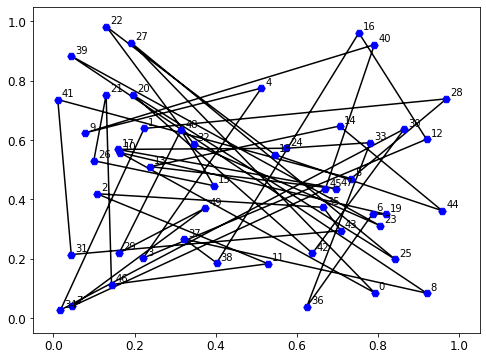

Linked list format (rec variable):
 tensor([10, 34, 35,  4,  9, 28, 36, 49, 37, 40, 19,  2,  3, 14, 44, 26, 12, 47,
        22,  6, 25, 46, 32, 39, 17, 27, 21,  0,  1, 48, 42, 41, 23, 24, 30, 43,
        33, 38, 16,  8, 45,  5, 20, 31, 18,  7, 11, 13, 15, 29])

Here, the linked list format means:
edge 0-10 is in the solution
edge 1-34 is in the solution
edge 2-35 is in the solution
edge 3-4 is in the solution
edge 4-9 is in the solution
edge 5-28 is in the solution
edge 6-36 is in the solution
edge 7-49 is in the solution
edge 8-37 is in the solution
edge 9-40 is in the solution

Real solution after decoding (node visited in sequence):
 tensor([ 0, 10, 19,  6, 36, 33, 24, 17, 47, 13, 14, 44, 18, 22, 32, 23, 39,  8,
        37, 38, 16, 12,  3,  4,  9, 40, 45,  7, 49, 29, 48, 15, 26, 21, 46, 11,
         2, 35, 43, 31, 41,  5, 28,  1, 34, 30, 42, 20, 25, 27])


In [9]:
import torch
from matplotlib import pyplot as plt

def plot_tour(rec, coordinates, dpi = 300):
    real_seq = problem.get_order(rec.unsqueeze(0), return_solution = True)
    plt.figure(figsize=(8,6))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([-0.05, 1.05]*2)
    # plot the nodes
    plt.scatter(coordinates[:,0], coordinates[:,1], marker = 'H', s = 55, c = 'blue', zorder = 2)
    # plot the tour
    real_seq_coordinates = coordinates.gather(0,real_seq[0].unsqueeze(1).repeat(1,2))
    real_seq_coordinates = torch.cat((real_seq_coordinates, real_seq_coordinates[:1]),0)
    plt.plot(real_seq_coordinates[:,0], real_seq_coordinates[:,1], color = 'black', zorder = 1)
    # mark node
    for i,txt in enumerate(range(rec.size(0))):
        plt.annotate(txt,(coordinates[i,0]+0.01, coordinates[i,1]+0.01),)
    
    
    plt.show()

plot_tour(rec[0], coordinates_first)
print('Linked list format (rec variable):\n', rec[0])
print('\nHere, the linked list format means:')
for i in range(10):
    print(f'edge {i}-{rec[0,i]} is in the solution')

real_seq = problem.get_order(rec, return_solution = True)
print('\nReal solution after decoding (node visited in sequence):\n', real_seq[0])

### 4. Use pre-trained NeuOpt to solve this mini-batch

The codes here are dapated from the 'agent.rollout' function defined in file 'agent/ppo.py'


In [13]:
from utils import torch_load_cpu, get_inner_model, move_to
from problems.problem_cvrp import total_history
feasibility_history_base = [True] * (total_history)
T=100
val_m = 1
stall_limit = 10
record = False
show_bar = False

bs, gs, _ = batch['coordinates'].size()
batch = move_to(batch, agent.opts.device)
batch_aug_same = problem.augment(batch, val_m, only_copy=True)
batch_aug = problem.augment(batch, val_m)
batch_feature = problem.input_feature_encoding(batch_aug)

solutions = move_to(problem.get_initial_solutions(batch_aug_same), agent.opts.device)
solution_best = solutions.clone()

obj, context = problem.get_costs(batch_aug_same, solutions, get_context = True, check_full_feasibility = True)
obj = torch.cat((obj[:,None], obj[:,None],obj[:,None]),-1).clone()
context2 = torch.zeros(bs*val_m,9).to(solutions.device);context2[:,-1] = 1
feasibility_history = torch.tensor(feasibility_history_base).view(-1,total_history).expand(bs*val_m, total_history).to(obj.device)

solution_history = [solutions.clone()]
solution_best_history = [solution_best.clone()]
obj_history = [obj.clone()]        
feasible_history_recorded = [feasibility_history[:,0]]
action = None
reward = []
stall_cnt_ins = torch.zeros(bs * val_m).to(solution_best.device)

for t in tqdm(range(T), disable = agent.opts.no_progress_bar or not show_bar, desc = 'rollout', bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):       

    action = agent.actor(problem,
                        batch_aug_same,
                        batch_feature,
                        solutions,
                        context,
                        context2,
                        action)[0]

    solutions, rewards, obj, feasibility_history, context, context2, info = problem.step(batch_aug_same, 
                                                                                        solutions,
                                                                                        action,
                                                                                        obj,
                                                                                        feasibility_history,
                                                                                        t,
                                                                                        weights = 0)
    index = rewards[:,0] > 0.0
    solution_best[index] = solutions[index].clone()

    # record informations
    reward.append(rewards[:,0].clone())
    obj_history.append(obj.clone())
    if record: 
        solution_history.append(solutions.clone())
        solution_best_history.append(solution_best.clone())
        feasible_history_recorded.append(feasibility_history[:,0].clone())

    # augment if stall>0 (checking every step)
    if stall_limit > 0:
        batch_aug_temp = problem.augment(batch, val_m)
        stall_cnt_ins = stall_cnt_ins * (1 - index.float()) + 1
        index_aug = stall_cnt_ins >= stall_limit
        batch_aug['coordinates'][index_aug] = batch_aug_temp['coordinates'][index_aug]
        batch_feature = problem.input_feature_encoding(batch_aug)
        stall_cnt_ins[index_aug] *= 0


# assert
best_length = problem.get_costs(batch_aug_same, solution_best, get_context = False, check_full_feasibility = True)
assert (best_length - obj[:,1] < 1e-5).all(), (best_length, obj, best_length - obj[:,1])
assert (problem.augment(batch, val_m, only_copy=True)['coordinates'] == batch_aug_same['coordinates']).all()
out = (obj[:,1].reshape(bs, val_m).min(1)[0], # batch_size, 1
       torch.stack(obj_history,1).view(bs, val_m, T+1, -1).min(1)[0], # batch_size, T, 2/3
       torch.stack(reward,1).view(bs, val_m, T).max(1)[0], # batch_size, T
       None if not record else (solution_history, solution_best_history, feasible_history_recorded)
      )

In [14]:
print('best cost:', out[0][0])
print('best rec found:', solution_best[0])

best cost: tensor(5.8948)
best rec found: tensor([ 8, 20, 31, 37, 24, 14, 23, 46, 25, 17, 26, 42, 28, 32, 33, 49,  4, 10,
        15,  6, 21, 27, 39, 43, 18, 44,  2, 22, 40,  3, 12, 34, 48, 30,  7, 45,
         0, 38, 11, 41, 16,  9, 36, 35, 19, 47, 29,  5,  1, 13])


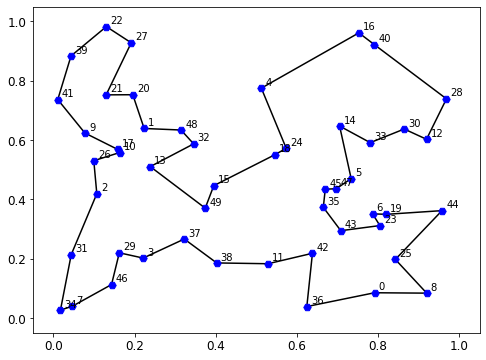

Linked list format (rec variable):
 tensor([ 8, 20, 31, 37, 24, 14, 23, 46, 25, 17, 26, 42, 28, 32, 33, 49,  4, 10,
        15,  6, 21, 27, 39, 43, 18, 44,  2, 22, 40,  3, 12, 34, 48, 30,  7, 45,
         0, 38, 11, 41, 16,  9, 36, 35, 19, 47, 29,  5,  1, 13])

Here, the linked list format means:
edge 0-8 is in the solution
edge 1-20 is in the solution
edge 2-31 is in the solution
edge 3-37 is in the solution
edge 4-24 is in the solution
edge 5-14 is in the solution
edge 6-23 is in the solution
edge 7-46 is in the solution
edge 8-25 is in the solution
edge 9-17 is in the solution

Real solution after decoding (node visited in sequence):
 tensor([ 0,  8, 25, 44, 19,  6, 23, 43, 35, 45, 47,  5, 14, 33, 30, 12, 28, 40,
        16,  4, 24, 18, 15, 49, 13, 32, 48,  1, 20, 21, 27, 22, 39, 41,  9, 17,
        10, 26,  2, 31, 34,  7, 46, 29,  3, 37, 38, 11, 42, 36])


In [15]:
coordinates_first = batch['coordinates'][0]
plot_tour(solution_best[0], coordinates_first)
print('Linked list format (rec variable):\n', solution_best[0])
print('\nHere, the linked list format means:')
for i in range(10):
    print(f'edge {i}-{solution_best[0,i]} is in the solution')

real_seq = problem.get_order(solution_best, return_solution = True)
print('\nReal solution after decoding (node visited in sequence):\n', real_seq[0])